# Equalização de Histograma

Bem-vindo ao mundo da equalização de histogramas! Apesar de já termos plotado histogramas e até mesmo feito um projeto relacionado a esta técnica no módulo passado, neste Módulo nós mergulharemos no fascinante domínio do processamento de imagens e exploraremos o conceito de **equalização de histogramas**. 

A equalização de histogramas é uma técnica poderosa usada no processamento de imagens para **redistribuir as intensidades de pixel de uma imagem**, resultando em uma representação mais equilibrada e contrastada.

> Ao ajustar a distribuição dos valores de pixel, **podemos realçar os detalhes e revelar características oculta**.

Ao longo deste *notebook*, exploraremos a teoria por trás da equalização, suas aplicações em vários domínios e como implementá-la usando o OpenCV. Cobriremos técnicas de equalização de imagem em escala de cinza e colorida, e também veremos uma técnica mais avançada e específica, chamada *Contrast Limited Adaptive Histogram Equalization* (CLAHE).

## Teoria e Aplicações

As aplicações da equalização de histogramas são vastas e diversas. Ela é comumente usada em tarefas de **aprimoramento de imagem, onde o objetivo é melhorar a qualidade visual das imagens**, realçando o contraste e revelando detalhes de difícil percepção ao nosso olho.

Encontrada em aplicações dos mais diversos domínios, como imagens médicas, imagens de satélite, sistemas de vigilância, entre outras, ao equalizar imagens que possam ter sido obscurecidas por condições como iluminação inadequada, conseguimos revelar características que permitam a extração de informações até então ignoradas ou desconhecidas.

Afinal, o histograma representa a distribuição das intensidades de pixel em uma imagem, com o eixo x representando os valores de intensidade e o eixo y representando a frequência de ocorrência. Ao equalizá-lo, buscamos espalhar as intensidades em uma faixa mais ampla, resultando em uma distribuição o mais uniforme possível.

Ou seja, no final o que fazemos é remapear os valores de intensidade originais para novos valores usando uma função de transformação que irá "esticar" ou "comprimir" efetivamente o valores ao longo de toda a extensão existente.

No trecho de código abaixo, utilizei o `numpy` apenas para te dar um *intuition* sobre a teoria. Então, primeiro calculo o histograma da imagem usando `np.histogram()`, que retorna os valores do histograma (`hist`) e as bordas dos intervalos (`bins`).

Para calcular a função de distribuição acumulada (CDF, em inglês), utilizo `hist.cumsum()` e normalizo a mesma, escalonando-a para a faixa do histograma. Para normalizar, usei `cdf_normalized = cdf * hist.max() / cdf.max()`.


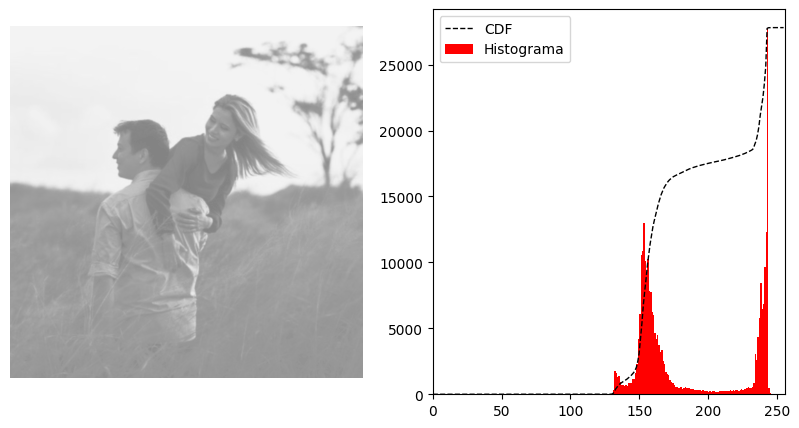

In [1]:
# Importando as bibliotecas necessárias
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Configurando os parâmetros de exibição de imagens e gráficos
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rcParams['image.interpolation'] = 'bicubic'
%matplotlib inline

# Carrega uma foto em grayscale
image_path = '../../data/carlos_hist.jpg'
image = cv2.imread(image_path, 0)

# Calcule o histograma
hist, bins = np.histogram(image.flatten(), 256, [0, 256])

# Compute a função de distribuição acumulada
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()


# Plotar histograma e C.D.F.
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image, vmin=0, vmax=255)
axs[0].axis('off')
axs[1].plot(cdf_normalized, color='black', linestyle='--', linewidth=1)
axs[1].set_xlim([0, 256])
axs[1].hist(image.flatten(), 256, [0, 256], color='r')
axs[1].legend(('CDF', 'Histograma'), loc='upper left')
plt.show()

Você pode ver que o histograma para a imagem predomina na região mais clara, indicando que as intensidades estão concentradas em uma parte específica do espectro. Isso deixa grande parte da faixa de intensidade disponível inutilizada, limitando o contraste e o apelo visual da imagem.

> Na equalização do histograma, queremos o espectro completo de intensidades, distribuindo os valores de pixel mais uniformemente ao longo do eixo x.

Para alcançar essa distribuição de intensidades e, assim, melhorar o contraste e a qualidade visual da imagem, veja como podemos utilizar o conceito de *masked array* do NumPy.


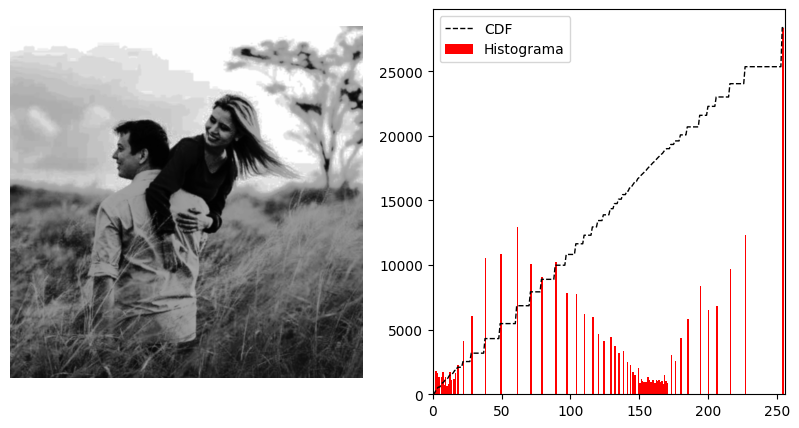

In [2]:
# Máscara para valores e normalização da CDF
cdf_m = np.ma.masked_equal(cdf, 0)
cdf_m = (cdf_m - cdf_m.min()) * 255 / (cdf_m.max() - cdf_m.min())
cdf = np.ma.filled(cdf_m, 0).astype('uint8')

# LUT (look-up table)
image2 = cdf[image]

# Novo histograma e CDF
hist2, bins2 = np.histogram(image2.flatten(), 256, [0, 256])
cdf2 = hist2.cumsum()
cdf_normalized2 = cdf2 * hist2.max() / cdf2.max()

# Plotar histograma e C.D.F.
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(image2, vmin=0, vmax=255)
axs[0].axis('off')
axs[1].plot(cdf_normalized2, color='black', linestyle='--', linewidth=1)
axs[1].set_xlim([0, 256])
axs[1].hist(image2.flatten(), 256, [0, 256], color='r')
axs[1].legend(('CDF', 'Histograma'), loc='upper left')
plt.show()

## Equalização de Histograma para imagens em tons de cinza

A função [**cv.equalizeHist()**](https://docs.opencv.org/4.7.0/d6/dc7/group__imgproc__hist.html#ga7e54091f0c937d49bf84152a16f76d6e) realiza a equalização do histograma de uma imagem em tons de cinza. A equalização implica mapear uma distribuição $H$ para outra distribuição $H'$ a fim de que os valores de intensidade sejam distribuídos ao longo de toda a faixa.

Para realizar o efeito de equalização, o remapeamento deve ser a função de distribuição acumulada(CDF, do inglês *cumulative distribution function*). Acompanhe o seguinte algoritmo:

1. Calcule o histograma $H$ para `src`.
2. Normalize o histograma de tal forma que o valor máximo seja 255 (ou o valor máximo para a intensidade da imagem).
3. Compute a integral discreta do histograma:

   $
   \begin{align}
   H'_{i} = \sum_{0 \leq j < i} H(j)
   \end{align}
   $

4. Transforme a imagem usando $H'$ como uma tabela de consulta (*look-up table*):

   $
   \begin{align}
   \text{dst}(x,y) = H'(\text{src}(x,y))
   \end{align}
   $

O algoritmo normaliza o brilho e aumenta o contraste da imagem.



### <font style="color:rgb(8,133,37)">Sintaxe da Função</font>

```python
retorno = cv.equalizeHist(src[, dst]) -> dst
```

**Parâmetros**

- **src** - Imagem de entrada em 8 bits e com um único canal (em tons de cinza).
- **dst** - Imagem de destino do mesmo tamanho e tipo que a imagem de entrada (src).

A equalização de histograma é uma técnica para ajustar o contraste de uma imagem, distribuindo os valores dos pixels de forma mais uniforme por toda a faixa de intensidade. Isso pode melhorar a aparência visual de uma imagem, tornando os detalhes mais visíveis. A função `cv.equalizeHist` realiza esse processo de forma eficiente, tornando-a uma ferramenta útil em muitas aplicações de processamento de imagem.

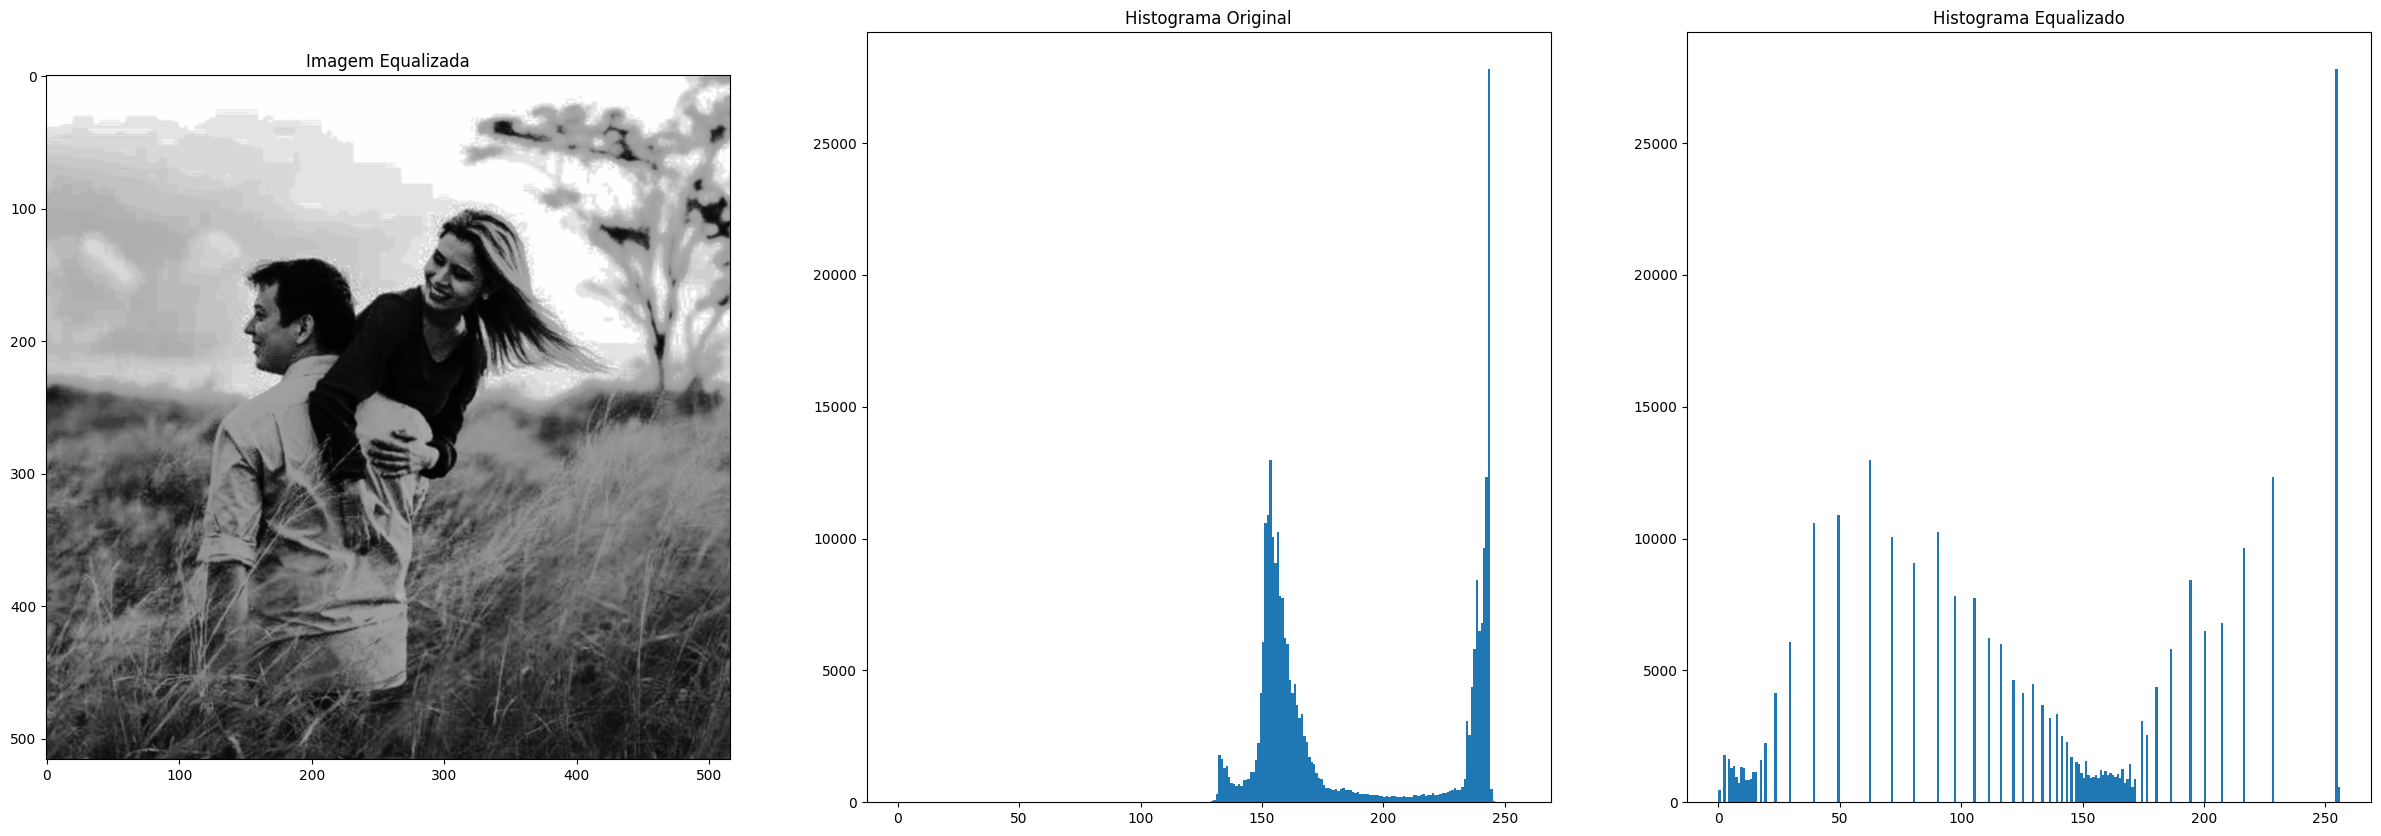

In [3]:
equalized = cv2.equalizeHist(image)

plt.figure(figsize=(30, 10))

# Mostrar imagem equalizada
plt.subplot(1, 3, 1)
plt.imshow(equalized, cmap='gray', vmin=0, vmax=255)
plt.title('Imagem Equalizada')

# Comparar histogramas
# O histograma original e equalizado são plotados lado a lado para análise
plt.subplot(1, 3, 2)
plt.hist(image.flatten(), 256, [0, 256])
plt.title('Histograma Original')

plt.subplot(1, 3, 3)
plt.hist(equalized.flatten(), 256, [0, 256])
plt.title('Histograma Equalizado')

plt.show()

### Equalização em imagens coloridas

Se tentarmos realizar a equalização de histograma em imagens coloridas, tratando cada um dos três canais separadamente, teremos um resultado ruim e inesperado. O motivo é que, quando cada canal de cor é transformado de maneira não linear e independente, podem ser geradas cores completamente novas e que não estarão relacionadas de nenhuma maneira.

A maneira correta de realizar a equalização de histograma em imagens coloridas envolve uma etapa anterior, que é a conversão para um espaço de com como o HSV, onde a intensidade se encontra separada. Então, esses são os passos que devem ser seguidos:

1. Transforme a imagem para o espaço de cores HSV.
2. Realize a equalização de histograma apenas no canal V.
3. Transforme a imagem de volta para o espaço de cores RGB.

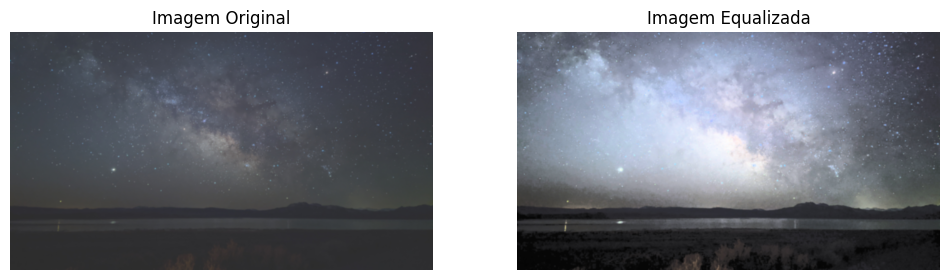

In [4]:
import cv2
import matplotlib.pyplot as plt

# Ler a astrofotografia
astrofoto = cv2.imread('../../data/astrofoto.jpg')

# Converter para o espaço de cores HSV
hsv_astrofoto = cv2.cvtColor(astrofoto, cv2.COLOR_BGR2HSV)

# Dividir os canais HSV
h, s, v = cv2.split(hsv_astrofoto)

# Equalizar o canal V (valor)
v_equalized = cv2.equalizeHist(v)

# Mesclar os canais HSV de volta, com o canal V equalizado
hsv_astrofoto = cv2.merge([h, s, v_equalized])

# Converter de volta para o espaço de cores RGB
astrofoto_equalized = cv2.cvtColor(hsv_astrofoto, cv2.COLOR_HSV2RGB)

# Configurar a figura
plt.figure(figsize=(12, 6))

# Mostrar imagem original
plt.subplot(1, 2, 1)
plt.imshow(astrofoto[..., ::-1], vmin=0, vmax=255)
plt.title('Imagem Original')
plt.axis('off')

# Mostrar imagem equalizada
plt.subplot(1, 2, 2)
plt.imshow(astrofoto_equalized, vmin=0, vmax=255)
plt.title('Imagem Equalizada')
plt.axis('off')

plt.show()

## CLAHE (Contrast Limited Adaptive Histogram Equalization)

CLAHE, ou Contrast Limited Adaptive Histogram Equalization, é uma técnica avançada de processamento de imagens para melhorar o contraste em uma imagem. Enquanto a equalização de histograma padrão aplica a mesma transformação a toda a imagem (o que pode aumentar o contraste, mas também pode intensificar o ruído e reduzir a gama dinâmica em áreas que já possuem bom contraste), o CLAHE divide a imagem em pequenos blocos, ou "tiles" (geralmente 8x8), e aplica a equalização de histograma a cada um desses blocos individualmente.

Isso permite que o contraste seja melhorado localmente, preservando detalhes e reduzindo o ruído. Além disso, o método CLAHE tem a capacidade de limitar o aumento do contraste (daí o termo "Contrast Limited"), impedindo a amplificação do ruído que pode ocorrer na técnica regular.

A implementação do CLAHE no OpenCV é feita usando a função `createCLAHE()`. Primeiro, um objeto CLAHE é criado com dois argumentos opcionais: `clipLimit` e `tileGridSize`.


clipLimit é o limite para o contraste, e tileGridSize é o tamanho do bloco para a equalização local. Uma vez criado o objeto CLAHE, o método apply() pode ser chamado na imagem de entrada para obter a imagem com equalização de histograma adaptativa.

Em resumo, embora a equalização de histograma seja uma técnica eficaz para melhorar o contraste em imagens, ela pode resultar em perda de detalhes e aumento do ruído. O CLAHE, ao contrário, oferece aprimoramento de contraste adaptativo e limitado, preservando os detalhes da imagem e minimizando a amplificação do ruído.

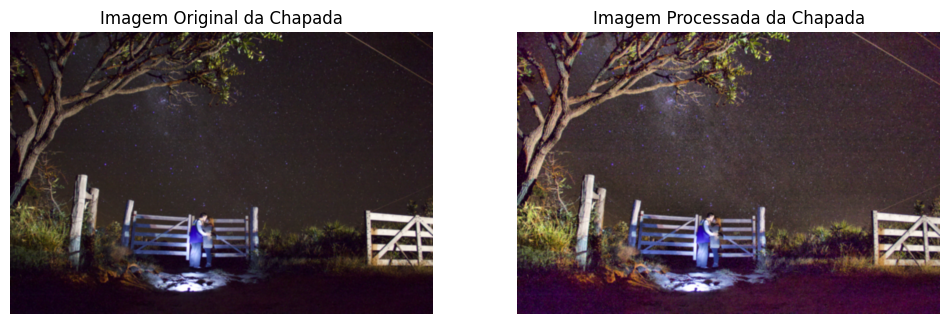

In [8]:
# Ler a imagem da chapada
chapada = cv2.imread('../../data/chapada.png')

# Converter para o espaço de cores HSV
chapada_hsv = chapada.copy()
chapada_hsv = cv2.cvtColor(chapada, cv2.COLOR_BGR2HSV)

# # Equalização global (comentar e rodar de novo após)
# h, s, v = cv2.split(chapada_hsv)
# global_equalized = cv2.equalizeHist(v)
# chapada_hsv = cv2.merge([h, s, global_equalized])

# # Criar um objeto CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
chapada_hsv[:, :, 2] = clahe.apply(chapada_hsv[:, :, 2])

# Converter de volta para o espaço de cores RGB
chapada_equalized = cv2.cvtColor(chapada_hsv, cv2.COLOR_HSV2BGR)
cv2.imwrite('chapada_equalized.png', chapada_equalized)

# Configurar a figura
plt.figure(figsize=(12, 6))

# Mostrar imagem original
plt.subplot(1, 2, 1)
plt.imshow(chapada[..., ::-1], vmin=0, vmax=255)
plt.title('Imagem Original da Chapada')
plt.axis('off')

# Mostrar imagem processada
plt.subplot(1, 2, 2)
plt.imshow(chapada_equalized[..., ::-1], vmin=0, vmax=255)
plt.title('Imagem Processada da Chapada')
plt.axis('off')

plt.show()
